In [145]:
import pandas as pd
import unicodedata

from tqdm import tqdm
tqdm.pandas(desc="Progress")

In [5]:
import os
path = os.getcwd()
path

'/Users/ryanphung/Projects/Linguistics/chinese-hanviet'

In [77]:
# Step 1: read Chinese words from a frequency list
df_chinese_words = pd.read_csv('inputs/leeds.txt', sep=' ', names=['rank','frequency','word'], skiprows=[0,1,2,3])
df_chinese_words

,rank,frequency,word
0,1,66293.28,，
1,2,45402.97,的
2,3,14216.88,了
3,4,12935.94,我
4,5,11879.45,一
...,...,...,...
49995,49996,0.63,陕西人
49996,49997,0.63,封建制度
49997,49998,0.63,牛郎织女
49998,49999,0.63,着眼点


In [78]:
# add pinyin

import pinyin
print(pinyin.get('你好'))

df_chinese_words['pinyin'] = df_chinese_words.progress_apply(
    lambda x:pinyin.get(str(x['word'])),
    axis=1
)

nǐhǎo


Progress: 100%|██████████| 50000/50000 [00:01<00:00, 28388.57it/s]


In [79]:
# add traditional

df_chinese_words['traditional'] = df_chinese_words.progress_apply(
    lambda x:chinese_converter.to_traditional(str(x['word'])),
    axis=1
)

Progress: 100%|██████████| 50000/50000 [00:01<00:00, 42591.68it/s]


In [80]:
# read Thieu Chuu character dictionary

df_chars = pd.read_csv('inputs/thieuchuu.txt', sep=r'=|\s\[|\]', names=['character', 'hanviet', 'pinyin', 'meaning'], engine='python')
df_chars

,character,hanviet,pinyin,meaning
0,一,nhất,yi1,"\n\t1. Một, là số đứng đầu các số đếm. Phàm vậ..."
1,丁,"đinh, chênh",ding1|zheng1,"\n\t1. Can Ðinh, can thứ tư trong mười can. \n..."
2,七,thất,qi1,"\n\t1. Bảy, tên số đếm. \n\t2. Có nghĩa chỉ về..."
3,万,"vạn, mặc",mo4|wan4,"\n\t1. Muôn, cũng như chữ vạn 萬. \n\t2. Một âm..."
4,丈,trượng,zhang4,"\n\t1. Trượng, mười thước ta là một trượng. \n..."
...,...,...,...,...
10021,龟,"quy, cưu, quân",gui1|jun1|qiu1,\n\t1. Con rùa rùa. Tính chậm chạp mà thọ hàng...
10022,龝,thu,qiu1,\n\t1. Cùng nghĩa như chữ thu 秋.
10023,龠,"dược, thược",yue4,"\n\t1. Cái dược, một thứ như cái sáo có ba lỗ...."
10024,龡,xúy,chui1,\n\t1. Cùng nghĩa với chữ xúy 吹 đi với chữ cổ ...


In [169]:
# Function to get Han Viet sound from Chinese word
def get_hanviet(word):
    result = []
    
    for c in word:
        df_of_c = df_chars[df_chars['character'] == c]
        if df_of_c.empty:
            return
        c_hv = df_of_c['hanviet'].values[0].split(', ')
        if (len(result) == 0):
            result = c_hv
        else:
            row = result
            result = []
            for i in row:
                for j in c_hv:
                    result.append(' '.join([i, j]))
    
    return result

# Test
print(get_hanviet('利害'))
print(get_hanviet('我们'))
print(get_hanviet('看看'))
print(get_hanviet('国际'))
print(get_hanviet('国際')) #Traditional too!
print(get_hanviet('怎么办')) #Should get from traditional
print(get_hanviet('怎麼辦'))
print(get_hanviet('有着')) # Should combine output from simplified and traditional
print(get_hanviet('通过')) # Oops, thông quá?
print(get_hanviet('通過'))

['lợi hại', 'lợi hạt']
['ngã môn']
['khán khán']
['quốc tế']
['quốc tế']
None
['chẩm ma bạn', 'chẩm ma biện']
['hữu khán', 'dựu khán']
['thông quá']
['thông quá', 'thông qua']


In [170]:
import chinese_converter

# Function to get Han Viet sound from Chinese word (by converting to traditional Chinese first)
def get_full_hanviet(word):
    result = get_hanviet(word)
    traditional = chinese_converter.to_traditional(word)
    
    if traditional != word:
        result_traditional = get_hanviet(traditional)
        result = (result or []) + (result_traditional or [])
        result = list(set(result))
    
    return ', '.join(result) if result else None

# Test
print(get_full_hanviet(','))
print(get_full_hanviet('利害'))
print(get_full_hanviet('我们'))
print(get_full_hanviet('看看'))
print(get_full_hanviet('国际'))
print(get_full_hanviet('国際')) #Traditional too!
print(get_full_hanviet('怎么办')) #Should get from traditional
print(get_full_hanviet('怎麼辦'))
print(get_full_hanviet('有着')) # Should combine output from simplified and traditional
print(get_full_hanviet('通过'))
print(get_full_hanviet('通過'))

None
lợi hại, lợi hạt
ngã môn
khán khán
quốc tế
quốc tế
chẩm ma biện, chẩm ma bạn
chẩm ma bạn, chẩm ma biện
hữu trứ, dựu khán, hữu khán, dựu trứ
thông quá, thông qua
thông quá, thông qua


In [84]:
# Step 2: find all Han Viet sound of these Chinese words

df_chinese_words['hanviet'] = df_chinese_words.progress_apply(lambda x:get_full_hanviet(str(x['word'])), axis=1)
df_chinese_words

Progress: 100%|██████████| 50000/50000 [03:54<00:00, 213.19it/s]


,rank,frequency,word,pinyin,traditional,hanviet
0,1,66293.28,，,，,，,None
1,2,45402.97,的,de,的,"đích, để"
2,3,14216.88,了,le,瞭,"liễu, liệu"
3,4,12935.94,我,wǒ,我,ngã
4,5,11879.45,一,yī,一,nhất
...,...,...,...,...,...,...
49995,49996,0.63,陕西人,shǎnxīrén,陝西人,None
49996,49997,0.63,封建制度,fēngjiànzhìdù,封建制度,"phong kiến chế độ, phong kiến chế đạc, phong k..."
49997,49998,0.63,牛郎织女,níulángzhīnv̌,牛郎織女,None
49998,49999,0.63,着眼点,zháoyǎndiǎn,著眼點,"trứ nhãn điểm, khán nhãn điểm"


In [105]:
df_chinese_words_with_hanviet = df_chinese_words#[df_chinese_words['hanviet'].notnull()]
df_chinese_words_with_hanviet

,rank,frequency,word,pinyin,traditional,hanviet
0,1,66293.28,，,，,，,None
1,2,45402.97,的,de,的,"đích, để"
2,3,14216.88,了,le,瞭,"liễu, liệu"
3,4,12935.94,我,wǒ,我,ngã
4,5,11879.45,一,yī,一,nhất
...,...,...,...,...,...,...
49995,49996,0.63,陕西人,shǎnxīrén,陝西人,None
49996,49997,0.63,封建制度,fēngjiànzhìdù,封建制度,"phong kiến chế độ, phong kiến chế đạc, phong k..."
49997,49998,0.63,牛郎织女,níulángzhīnv̌,牛郎織女,None
49998,49999,0.63,着眼点,zháoyǎndiǎn,著眼點,"trứ nhãn điểm, khán nhãn điểm"


In [106]:
# df_chinese_words_with_hanviet.to_csv('outputs/chinese-words-with-hanviet.tsv', sep='\t', index_label=['no'])

In [107]:
# Read a Viet Phrases dictionary

df_vietphrases = pd.read_csv('inputs/vietphrases.txt', sep='=', names=['phrase', 'meaning'])
df_vietphrases

,phrase,meaning
0,充满希望的跋涉比到达目的地更能给人乐趣,sung mãn hi vọng đích bạt thiệp bỉ đáo đạt mục...
1,充滿希望的跋涉比到達目的地更能給人樂趣,sung mãn hi vọng đích bạt thiệp bỉ đáo đạt mục...
2,来的时候是这么来的走的时候也就这么走了,khi tới như thế nào/khi đi cũng như vậy
3,无一事而不学无一时而不学无一处而不得,vô nhất sự nhi bất học/vô nhất thì nhi bất học...
4,無一事而不學無一時而不學無一處而不得,vô nhất sự nhi bất học/vô nhất thì nhi bất học...
...,...,...
107306,鹅,nga/ngan/ngỗng
107307,麻,ma/tê dại
107308,黏,dính
107309,鼻,mũi


In [108]:
df_chinese_words_with_hanviet_and_meaning = df_chinese_words_with_hanviet.join(df_vietphrases.set_index('phrase'), on='word', how='inner')
df_chinese_words_with_hanviet_and_meaning

,rank,frequency,word,pinyin,traditional,hanviet,meaning
1,2,45402.97,的,de,的,"đích, để",đích
2,3,14216.88,了,le,瞭,"liễu, liệu",/liễu
3,4,12935.94,我,wǒ,我,ngã,ta
4,5,11879.45,一,yī,一,nhất,một/nhất
5,6,9854.95,在,zài,在,tại,ở
...,...,...,...,...,...,...,...
49983,49984,0.63,白肉,báiròu,白肉,"bạch nhục, bạch nhụ, bạch nậu",thịt luộc/thịt lợn luộc
49984,49985,0.63,成林,chénglín,成林,thành lâm,thành rừng
49988,49989,0.63,交合,jiāohé,交合,"giao hợp, giao cáp",giao hợp/tính giao/giao cấu
49993,49994,0.63,暖烘烘,nuǎnhōnghōng,暖烘烘,noãn hồng hồng,ấm áp dễ chịu


In [109]:
# Function to find if the Han Viet sounds match a word in the meaning

def match(a, b):
    if not a or not b:
        return
    for a_part in a.split(', '):
        if a_part.lower() in map(lambda x:x.lower(), b.split('/')):
            return a_part
    
print(match('thành lâm', 'thành rừng'))
print(match('chế độ, chế đạc', 'chế độ'))
print(match('giao hợp, giao cáp', 'giao hợp/tính giao/giao cấu'))
print(match('bắc kinh', 'Bắc Kinh'))

None
chế độ
giao hợp
bắc kinh


In [110]:
df_chinese_words_with_hanviet_and_meaning['matched'] = df_chinese_words_with_hanviet_and_meaning.progress_apply(
    lambda x:match(str(x['hanviet']), str(x['meaning'])),
    axis=1
)
df_chinese_words_with_hanviet_and_meaning

Progress: 100%|██████████| 30033/30033 [00:00<00:00, 35512.38it/s]


,rank,frequency,word,pinyin,traditional,hanviet,meaning,matched
1,2,45402.97,的,de,的,"đích, để",đích,đích
2,3,14216.88,了,le,瞭,"liễu, liệu",/liễu,liễu
3,4,12935.94,我,wǒ,我,ngã,ta,None
4,5,11879.45,一,yī,一,nhất,một/nhất,nhất
5,6,9854.95,在,zài,在,tại,ở,None
...,...,...,...,...,...,...,...,...
49983,49984,0.63,白肉,báiròu,白肉,"bạch nhục, bạch nhụ, bạch nậu",thịt luộc/thịt lợn luộc,None
49984,49985,0.63,成林,chénglín,成林,thành lâm,thành rừng,None
49988,49989,0.63,交合,jiāohé,交合,"giao hợp, giao cáp",giao hợp/tính giao/giao cấu,giao hợp
49993,49994,0.63,暖烘烘,nuǎnhōnghōng,暖烘烘,noãn hồng hồng,ấm áp dễ chịu,None


In [134]:
df_multisyllabic = df_chinese_words_with_hanviet_and_meaning[df_chinese_words_with_hanviet_and_meaning['word'].str.len() > 1]
df_multisyllabic['chinese_rank'] = df_multisyllabic.reset_index().index

df_multisyllabic

<ipython-input-134-f2326ab5ba90>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_multisyllabic['chinese_rank'] = df_multisyllabic.reset_index().index


,rank,frequency,word,pinyin,traditional,hanviet,meaning,matched,chinese_rank
24,25,2837.94,我们,wǒmen,我們,ngã môn,chúng ta/chúng tôi/chúng tao/chúng tớ,None,0
31,32,2157.07,没有,méiyǒu,沒有,"một hữu, một dựu",không có/không/không bằng/không đủ/không tới/k...,None,1
41,42,1921.32,自己,zìjǐ,自己,tự kỷ,chính mình/chính/tự mình/bản thân/mình/nhà,None,2
47,48,1674.90,他们,tāmen,他們,tha môn,bọn họ/chúng nó/họ,None,3
59,60,1512.01,什么,shíyāo,什麼,thập ma,cái gì/gì/nào/gì đó/nhậm chỉ/mọi thứ/nấy/cái q...,None,4
...,...,...,...,...,...,...,...,...,...
49983,49984,0.63,白肉,báiròu,白肉,"bạch nhục, bạch nhụ, bạch nậu",thịt luộc/thịt lợn luộc,None,28952
49984,49985,0.63,成林,chénglín,成林,thành lâm,thành rừng,None,28953
49988,49989,0.63,交合,jiāohé,交合,"giao hợp, giao cáp",giao hợp/tính giao/giao cấu,giao hợp,28954
49993,49994,0.63,暖烘烘,nuǎnhōnghōng,暖烘烘,noãn hồng hồng,ấm áp dễ chịu,None,28955


In [149]:
df_matched = df_multisyllabic[df_multisyllabic['matched'].notnull()]
df_matched['index'] = df_matched.reset_index().index + 1
df_matched

<ipython-input-149-7d394d684079>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_matched['index'] = df_matched.reset_index().index + 1


,rank,frequency,word,pinyin,traditional,hanviet,meaning,matched,chinese_rank,index
67,68,1332.15,可以,kěyǐ,可以,"khả dĩ, khắc dĩ",có thể/khả dĩ/có khả năng/có năng lực/cho phép...,khả dĩ,5,1
80,81,1106.78,中国,zhōngguó,中國,"trúng quốc, trung quốc",Trung Quốc/Trung Hoa Trung Quốc/China/nước cộn...,trung quốc,8,2
96,97,916.48,现在,xiànzài,現在,hiện tại,hiện tại/hiện nay/bây giờ,hiện tại,13,3
104,105,831.20,时间,shíjiān,時間,"thì gian, thời gian",thời gian/giờ/khoảng thời gian/thời điểm,thời gian,16,4
112,113,775.81,问题,wèntí,問題,vấn đề,vấn đề/câu hỏi/đề hỏi/quan trọng/mấu chốt/chuy...,vấn đề,18,5
...,...,...,...,...,...,...,...,...,...,...
49947,49948,0.63,飞毛腿,fēimáotǔi,飛毛腿,"phi mao thối, phi mô thối",phi mao thối/chạy nhanh/nhanh chân/cặp giò đi ...,phi mao thối,28942,8137
49950,49951,0.63,民以食为天,mínyǐshíwèitiān,民以食為天,"dân dĩ thực vi thiên, dân dĩ tự vi thiên",dân dĩ thực vi thiên,dân dĩ thực vi thiên,28943,8138
49967,49968,0.63,谢恩,xièēn,謝恩,tạ ân,tạ ơn/tạ ân,tạ ân,28946,8139
49973,49974,0.63,尧舜,yáoshùn,堯舜,nghiêu thuấn,Nghiêu Thuấn,nghiêu thuấn,28948,8140


In [167]:
df_matched.to_csv('outputs/chinese-hanviet-cognates.tsv', sep='\t', index=False, columns=['index', 'chinese_rank', 'frequency', 'word', 'traditional', 'pinyin', 'matched', 'meaning'])

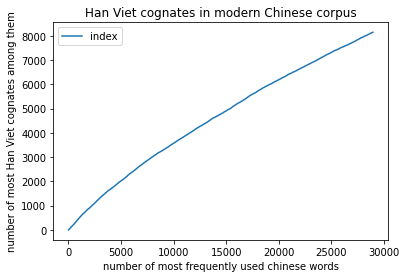

In [171]:
ax = df_matched.plot(x="chinese_rank", y="index",
                title="Han Viet cognates in modern Chinese corpus",
                xlabel="number of most frequently used chinese words",
                ylabel="number of most Han Viet cognates among them"
               )

In [174]:
fig = ax.get_figure()
fig.savefig('outputs/chart.png')